In this notebook, I aim to roll through an analysis across two patients which can easily be extended for all of the  patients in your cohort. To do so, we will use the pre-processing functions that are written out more explicitly in the step-by-step notebooks. 

**This is the notebook you should copy and edit for your own actual analyses**

======================================================================================================================

These are magics that provide certain functionality. Specifically, if you edit functions that are called in this notebook, the functions are reloaded so the changes propagate here without needing to reload the notebook.


In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [60]:
import numpy as np
import mne
from glob import glob
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from scipy.stats import zscore, linregress
import pandas as pd
from mne.preprocessing.bads import _find_outliers
import fooof
from fooof import FOOOFGroup
import os 
import joblib
import emd
import statsmodels.formula.api as smf
import statsmodels.api as sm

Note: If you have installed the LFPAnalysis package in editable form on Minerva, you must append the local path! This is because Minerva requires that you point your package installs away from the local directory for space reasons, but editable packages have to be installed locally.

In [3]:
import sys
sys.path.append('/hpc/users/qasims01/resources/LFPAnalysis')

In [4]:
from LFPAnalysis import lfp_preprocess_utils, sync_utils, analysis_utils, nlx_utils

## Load, pre-process and re-reference the neural data

Substitute your own patients in the following cell: 

In [6]:
# Specify root directory for un-archived data and results 
base_dir = '/sc/arion' 
# Specify subject names 
subj_ids = ['MS012', 'MS025']
# My task has multiple days. Yours probably does not. So you can remove this line in your code: 
day = 'Day1'
# Specify the format being loaded. Probably smart to put subjects and their format in a dataframe. 
subj_formats = ['edf', 'edf']
elec_dict = {f'{x}': {f'{y}': [] for y in days} for x in subj_ids}
mne_dict = {f'{x}': {f'{y}': [] for y in days} for x in subj_ids}
photodiode_dict = {f'{x}': {f'{y}': [] for y in days} for x in subj_ids}

## Pre-process (run 1x): 

In the pre-processing functions below, we: 

1. load the raw data (either a .edf file or a folder of .nlx files) into mne objects for use with the mne toolbox: https://mne.tools/stable/index.html.

2. load the localized electrode names from the .csv or .xlsx file listing their MNI coordinates into the mne object

3. filter and resample as necessary

4. re-reference to a proximal white matter electrode (or bipolar, if desired) 

In [7]:
for ix, subj_id in enumerate(subj_ids): 
    # Set paths
    load_path = f'{base_dir}/projects/guLab/Salman/EMU/{subj_id}/neural/{day}'
    elec_path = f'{base_dir}/projects/guLab/Salman/EMU/{subj_id}/anat/'
    save_path = f'{base_dir}/work/qasims01/MemoryBanditData/EMU/Subjects/{subj_id}/neural/{day}'
    # Check if path exists for saving, and if not, make it
    if not os.path.exists(save_path):
        os.makedirs(save_path)

    # electrode files could either be csv or excel
    elec_files = glob(f'{elec_path}/*.csv') + glob(f'{elec_path}/*.xlsx')
    # There should really only be one, so grab it with the zero-index 
    elec_file = elec_files[0]

    # Make MNE file
    mne_data = lfp_preprocess_utils.make_mne(load_path=load_path, 
                                             elec_path=elec_file, 
                                             format=subj_formats[ix],
                                             return_data=True)

    # Re-reference neural data
    mne_data_reref = lfp_preprocess_utils.ref_mne(mne_data=mne_data, 
                                                  elec_path=elec_file, 
                                                  method='wm', 
                                                  site='MSSM')

    # Save this data so that you don't need this step again:
    mne_data_reref.save(f'{save_path}/wm_ref_ieeg.fif', overwrite=True)
        


/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/lfp_preprocess_utils.py:729: UserWarning: No photodiode channel specified - please check /sc/arion/projects/guLab/Salman/EMU/MS012/neural/Day1/photodiode.fif to make sure a valid sync signal was saved
  warnings.warn(f'No photodiode channel specified - please check {load_path}/photodiode.fif to make sure a valid sync signal was saved')
/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/lfp_preprocess_utils.py:767: RuntimeWarning: This filename (/sc/arion/projects/guLab/Salman/EMU/MS012/neural/Day1/photodiode.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  mne_data.save(f'{load_path}/photodiode.fif', picks=photodiode_name, overwrite=overwrite)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Don

 - mne_data: a Raw mne object, where the data has been loaded, filtered for line noise, searched for bad channels, parsed for different data types, and resampled if necessary. 
 
 - mne_data_reref: an mne object containing re-referenced data (either white matter or bipolar)

If you have ran the preprocessing above, load the data instead: 


In [8]:
for subj_id in subj_ids: 
    # Set paths
    load_path = f'{base_dir}/projects/guLab/Salman/EMU/{subj_id}/neural/{day}'
    elec_path = f'{base_dir}/projects/guLab/Salman/EMU/{subj_id}/anat/'
    save_path = f'{base_dir}/work/qasims01/MemoryBanditData/EMU/Subjects/{subj_id}/neural/{day}'

    elec_files = glob(f'{elec_path}/*.csv') + glob(f'{elec_path}/*.xlsx')
    # There should really only be one 
    elec_file = elec_files[0]
    elec_data = lfp_preprocess_utils.load_elec(elec_file)

    mne_data_reref = mne.io.read_raw_fif(f'{save_path}/wm_ref_ieeg.fif', preload=True)

    photodiode_data = mne.io.read_raw_fif(f'{load_path}/photodiode.fif', preload=True)

    # Append to list 
    mne_dict[subj_id][day].append(mne_data_reref)

    photodiode_dict[subj_id][day].append(photodiode_data)

    elec_dict[subj_id][day].append(elec_file)

/tmp/ipykernel_192979/2658989375.py:14: RuntimeWarning: This filename (/sc/arion/projects/guLab/Salman/EMU/MS012/neural/Day1/photodiode.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  photodiode_data = mne.io.read_raw_fif(f'{load_path}/photodiode.fif', preload=True)
/tmp/ipykernel_192979/2658989375.py:14: RuntimeWarning: This filename (/sc/arion/projects/guLab/Salman/EMU/MS025/neural/Day1/photodiode.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  photodiode_data = mne.io.read_raw_fif(f'{load_path}/photodiode.fif', preload=True)


 - mne_dict: a dictionary containing all of your subjects' re-referenced mne data 
 
 - photodiode_dict: a dictionary containing all of your subjects' photodiode data 
 
 - elec_dict: a dictionary containing the paths to your subjects' electrode data 

## Sync behavioral and neural data

Here, we perform a critical step: computing the time offset between the computer that recorded the neural data and the laptop that featured the experiment. 

The function here only requires a **subset** of detected sync signals (i.e. photodiode deflections) to be detected to successfully compute this offset. 

In [9]:
slopes = {f'{x}': {f'{y}': [] for y in days} for x in subj_ids}
offsets = {f'{x}': {f'{y}': [] for y in days} for x in subj_ids}

for subj_id in subj_ids: 
    for day in ['Day1']:
        
        # Load the behavioral timestamps: 
        
        behav_path = f'{base_dir}/projects/guLab/Salman/EMU/{subj_id}/behav/{day}'
        temp_df = pd.read_csv(glob(f'{behav_path}/*.csv')[0], index_col=None, header=0)
        beh_ts = temp_df[temp_df.keys()[temp_df.keys().str.startswith('sync') & temp_df.keys().str.endswith('started')]].values
        beh_ts = beh_ts[~np.isnan(beh_ts)] 
        
        # Synchronize to the photodiode or whatever your neural sync signal is
        slope, offset = sync_utils.synchronize_data(beh_ts, 
                                                    photodiode_dict[subj_id][day][0], 
                                                    smoothSize=11, windSize=15, height=1)

        slopes[subj_id][day].append(slope)
        offsets[subj_id][day].append(offset)


28 blocks
............................

found matches for 180 of 428 pulses
31 blocks
...............................

found matches for 300 of 469 pulses


 - slopes: a dictionary containing the slopes (should be ~ 1) for each subject
 - offsets: a dictionary containing the offsets for each subject

## Load your behavioral data

You probably have a separate notebook for processing the behavioral data for your task. Load the processed dataframe here:

In [10]:
behav_data = pd.read_csv(f'{base_dir}/work/qasims01/MemoryBanditData/EMU/learn_df.csv')

In [11]:
# Filter just to the participants in this notebook
behav_data = behav_data[behav_data.participant.isin(subj_ids)]

In [15]:
behav_data.head(5)[['participant', 'feedback_start', 'baseline_start']]

participant  feedback_start  baseline_start
0       MS012      243.239158      244.929025
1       MS012      248.344187      250.043187
2       MS012      254.083059      255.790670
3       MS012      258.148220      259.838892
4       MS012      261.943712      263.620631

## Make epochs

Make epochs and remove IEDs. Currently just doing this for one example period - when subjects receive feedback. 

Notes: 

- I also segment a baseline period for every event of interest. 

- I apply a buffer period of 1.0 seconds - this will be helpful when we compute spectrograms later. 

- The IED count for every channel is added to the epoch metadata

(I'm a little dumb, so my baseline is a fixation cross AFTER the trial, rather than before. A bit silly if you ask me.) 

In [16]:
# IED removal requires that we set some parameters for IED detection. 
# 1. peak_thresh: how many stds should they exceed the baseline by? 
# 2. closeness_thresh: how close should they be allowed to be (in sec) to other candidate IEDs? 
# 3. width_thresh: how wide should they have to be (in sec)?

# Defaults:
IED_args = {'peak_thresh':4,
           'closeness_thresh':0.25, 
           'width_thresh':0.2}

# Create a dictionary with your event name (matching your dataframe), and the time-window for the event
evs = {'feedback_start': [0, 1.5],
       'baseline_start': [0, 0.75]}

# Note: I am treating the baseline events just like ANY OTHER event

# add behavioral times of interest 
for subj_id in subj_ids:
    
    # Filter behavior to the specific subject
    subj_data = behav_data[behav_data.participant==subj_id]
    
    # Set paths
    load_path = f'{base_dir}/projects/guLab/Salman/EMU/{subj_id}/neural/{day}'
    save_path = f'{base_dir}/work/qasims01/MemoryBanditData/EMU/Subjects/{subj_id}/neural/{day}'

    epochs_all_evs = {f'{x}': np.nan for x in evs}
    epochs_all_baseline = {f'{x}': np.nan for x in evs}

    for event in evs.keys():
        # Make the epochs. 
        ev_epochs = lfp_preprocess_utils.make_epochs(load_path=f'{save_path}/wm_ref_ieeg.fif', 
                     elec_path=elec_dict[subj_id][day][0], 
                     slope=slopes[subj_id][day][0], offset=offsets[subj_id][day][0],
                     behav_name=event, behav_times=subj_data[event].values, 
                     ev_start_s=evs[event][0], ev_end_s=evs[event][1], buf_s = 1.0, 
                     downsamp_factor=2, IED_args=IED_args)

        epochs_all_evs[event] = ev_epochs
        epochs_all_evs[event].save(f'{save_path}/epoch_{event}.fif', overwrite=True)

/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/lfp_preprocess_utils.py:1073: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  elec_df['label'] = mne_data_reref.ch_names
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 3178 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done 4480 out of 4480 | elapsed:    8.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done  56 out of  56 | elapsed:    2.5s finished
/tmp/ipykernel_192979/1966325713.py:40: RuntimeWarning: This filename (/sc/arion/work/qasims01/Memor

 - epochs_all_evs: dictionary containing the epochs for all of your subjects' re-referenced data

Let's add behavioral data (from our dataframe) to our event epochs metadata:

In [17]:
# Create a dictionary with the name of the events that you want to pull out of your dataframe, and the time associated with them
evs = {'feedback_start': [0, 1.5],
       'baseline_start': [0, 0.75]}

epochs_all_subjs_all_evs = {f'{a}': {f'{b}': np.nan for b in evs.keys()} for a in subj_ids}

for subj_id in subj_ids:
    # Filter behavior to the specific subject
    subj_data = behav_data[behav_data.participant==subj_id]
    for event in evs.keys():
        
        load_path = f'{base_dir}/work/qasims01/MemoryBanditData/EMU/Subjects/{subj_id}/neural/{day}'
        ev_epochs = mne.read_epochs(f'{load_path}/epoch_{event}.fif', preload=True)
        
        epochs_all_subjs_all_evs[subj_id][event] = ev_epochs
        
        # Let's add our behavioral events to the metadata. Substitute this with the particulars for your behavioral dataframe. 

        event_metadata = epochs_all_subjs_all_evs[subj_id][event].metadata.copy()

        event_metadata['rt'] = subj_data['gamble_rt'].tolist()
        event_metadata['reward'] = subj_data['reward'].tolist()
        event_metadata['image_dprime'] = subj_data['DPRIME'].tolist()
        event_metadata['rpe'] = subj_data['rpe'].tolist()

        epochs_all_subjs_all_evs[subj_id][event].metadata = event_metadata
    

/tmp/ipykernel_192979/1867746500.py:13: RuntimeWarning: This filename (/sc/arion/work/qasims01/MemoryBanditData/EMU/Subjects/MS012/neural/Day1/epoch_feedback_start.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ev_epochs = mne.read_epochs(f'{load_path}/epoch_{event}.fif', preload=True)
/tmp/ipykernel_192979/1867746500.py:13: RuntimeWarning: This filename (/sc/arion/work/qasims01/MemoryBanditData/EMU/Subjects/MS012/neural/Day1/epoch_baseline_start.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ev_epochs = mne.read_epochs(f'{load_path}/epoch_{event}.fif', preload=True)
/tmp/ipykernel_192979/1867746500.py:13: RuntimeWarning: This filename (/sc/arion/work/qasims01/MemoryBanditData/EMU/Subjects/MS025/neural/Day1/epoch_feedback_start.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -e

In [19]:
epochs_all_subjs_all_evs['MS025']['feedback_start'].metadata.head(5)

lacas1-lacas4 lacas2-lacas4 lacas3-lacas4 lacas6-lacas5 laglt1-laglt5  \
0          None          None          None          None          None   
1          None          None          None          None          None   
2          None          None          None          None          None   
3          None          None          None          None          None   
4          None          None          None          None          None   

  laglt2-laglt5 laglt3-laglt5 laglt7-lhplt6 laglt8-lhplt7 laglt9-lhplt8  ...  \
0          None          None          None          None          None  ...   
1          None          None          None          None          None  ...   
2          None          None          None          None          None  ...   
3          None          None          None          None          None  ...   
4          None          None          None          None          None  ...   

  rpvnh1-rcmip8 rpvnh11-rpvnh9 rpvnh2-rcmip8 rpvnh3-rcmip7 rpvnh4-rcmip8  \
0          None           None          None          None          None   
1          None           None          None          None          None   
2          None           None          None          None          None   
3          None           None          None          None          None   
4          None           None          None          None          None   

  rpvnh5-rpvnh8         rt reward image_dprime       rpe  
0          None  16.255064    1.0     2.337818  0.500000  
1          None   4.730283    0.0     1.975903 -0.775057  
2          None   4.093465    1.0     1.726771  0.651313  
3          None   4.179714    0.0     1.675859 -0.500000  
4          None   1.786383    1.0     1.953028  0.293016  

[5 rows x 98 columns]

Plot and examine the epochs if you'd like

In [73]:
# %matplotlib notebook
# fig = epochs_all_subjs_all_evs['MS007']['feedback_start'].plot(n_epochs=10, n_channels=10)

In [74]:
# # Need this following line to save the annotations to the epochs object 
# fig.fake_keypress('a')

# Spectral analyses:

Here we are mostly going to make a lot of spectral plots and things to look over manually as a function of event timing.

## Power spectrum (FOOOF)

Here, we are going to plot the group-level FOOOF analysis for two conditions in the task across all channels, and then also plot the individual power spectrums for each channel with model fit for each of the two conditions. Note the time specification to make sure I leave out the baseline period... 

FOOOF's primary utility, imo, is not in peak parameterization but 1/f subtraction. Peak parameters are subject to over- and under-fitting, and fit quality has too strong of an effect. Simply contrasting *n* PSDs (for *n* conditions) after removing the 1/f is a more healthy approach.

Goals: 
- Plot the FOOOF results 
- Collect the FOOOF parameters 
- Subtract the 1/f 
- Save/return the corrected PSDs (and overlay plot them) 


Text(0.5, 1.0, 'Test Figure demonstrating FOOOF')

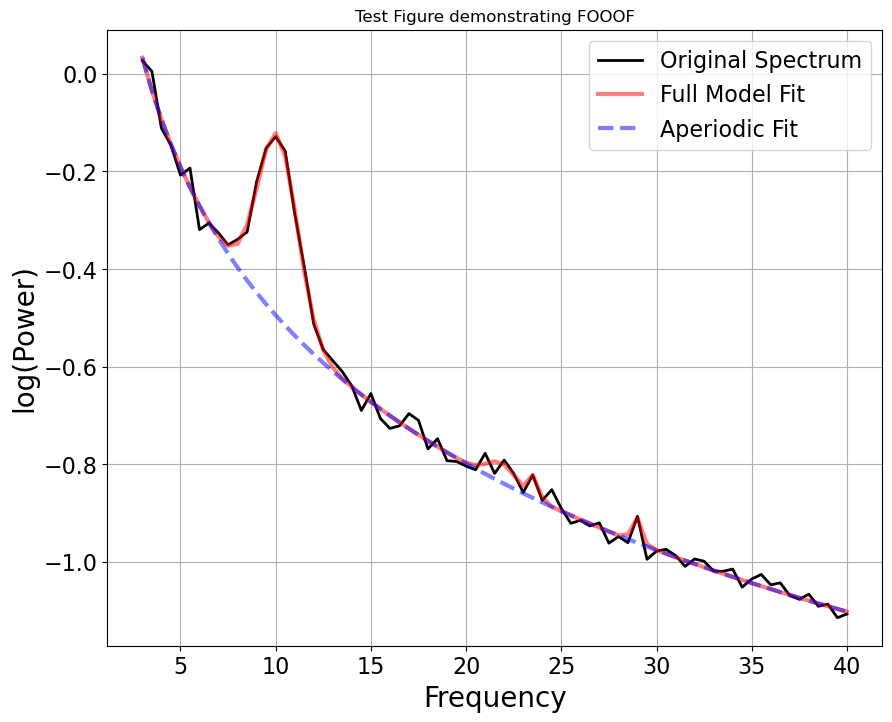

In [40]:
## Make a test figure of FOOOF 
# Import functions for creating simulated power spectra
from fooof.sim.gen import gen_power_spectrum, gen_group_power_spectra

# Import plotting functions
from fooof.plts.spectra import plot_spectrum, plot_spectra

# Import the FOOOF object
from fooof import FOOOF

# Create some new settings for simulating a group of power spectra
n_spectra = 2
freq_range = [3, 40]
nlv = 0.02

# Aperiodic params: define values for each spectrum, with length equal to n_spectra
aperiodic_params = [[0.5, 1], [1, 1.5]]

# Periodic parameters: define a single definition, to be applied to all spectra
periodic_params = [10, 0.4, 1]

# Simulate a group of power spectra
freqs, powers = gen_group_power_spectra(n_spectra, freq_range, aperiodic_params,
                                        periodic_params, nlv)

# Initialize a FOOOF object, and add some data to it
fm = FOOOF(verbose=False)
fm.add_data(freqs, powers[0])
# Fit the model, and plot the reconstruction
fm.fit()
fm.plot(save_fig=True, file_path='/sc/arion/work/qasims01/MemoryBanditData/EMU', file_name='sim_1.pdf')
plt.title('Test Figure demonstrating FOOOF')

# fm = FOOOF(verbose=False)
# fm.add_data(freqs, powers[1])
# # Fit the model, and plot the reconstruction
# fm.fit()
# fm.plot(save_fig=True, file_path='/sc/arion/work/qasims01/MemoryBanditData/EMU', file_name='sim_2.pdf')


## Compute FOOOF for epochs: 

In [45]:
evs = {'feedback_start': [0, 1.5],
       'baseline_start': [0, 0.75]}

# Define peak_width, peak_height, peak_threshold, max_n_peaks
FOOOF_kwargs = {'peak_width_limits': [1, 8], 
               'min_peak_height': 0.1,
                'peak_threshold': 1.,
                'max_n_peaks': 6,
               'freq_range': [1, 30]}
 
# Define our ROIs
rois = ['hippocampus', 'amygdala', 'insula', 'cingulate' ,'frontal']

for subj_id in subj_ids:
    save_path = f'{base_dir}/work/qasims01/MemoryBanditData/EMU/Subjects/{subj_id}'
    # Get electrode df 
    elec_path = f'{base_dir}/projects/guLab/Salman/EMU/{subj_id}/anat/'
    # electrode files could either be csv or excel
    elec_files = glob(f'{elec_path}/*.csv') + glob(f'{elec_path}/*.xlsx')
    # There should really only be one 
    elec_file = elec_files[0]
    
    elec_data = lfp_preprocess_utils.load_elec(elec_file)
    anode_list = [x.split('-')[0] for x in epochs_all_subjs_all_evs[subj_id][event].ch_names]
    elec_df = elec_data[elec_data.label.str.lower().isin(anode_list)]
    elec_df['label'] = epochs_all_subjs_all_evs[subj_id][event].ch_names
    
    for event in evs.keys():    
        filepath = f'{base_dir}/work/qasims01/MemoryBanditData/EMU/Subjects/{subj_id}/scratch/FOOOF/{event}'
        for region in rois: 
            file_path = f'{filepath}/{region}'    
            # sub-select channels and make directories if need be 
            picks = analysis_utils.select_picks_rois(elec_df, region)
            epochs_all_subjs_all_evs[subj_id][event].metadata['region'] = region
        
            # sub-select epochs 
            chan_epochs = epochs_all_subjs_all_evs[subj_id][event].copy().pick_channels(picks)

            FOOOFGroup_res = analysis_utils.FOOOF_compute_epochs(chan_epochs, tmin=evs[event][0], tmax=evs[event][1], 
                                                                **FOOOF_kwargs)

/tmp/ipykernel_192979/2100480730.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  elec_df['label'] = epochs_all_subjs_all_evs[subj_id][event].ch_names
/tmp/ipykernel_192979/2100480730.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  elec_df['label'] = epochs_all_subjs_all_evs[subj_id][event].ch_names


- FOOOFGroup_res: Object containing the results of the FOOOF fit. See https://fooof-tools.github.io/fooof/auto_tutorials/plot_06-FOOOFGroup.html#sphx-glr-auto-tutorials-plot-06-fooofgroup-py.

## Compare FOOOF for epochs between conditions:

In [76]:
evs = {'feedback_start': [0, 1.5],
       'baseline_start': [0, 0.75]}

# Define peak_width, peak_height, peak_threshold, max_n_peaks
FOOOF_kwargs = {'peak_width_limits': [1, 8], 
               'min_peak_height': 0.1,
                'peak_threshold': 1.,
                'max_n_peaks': 6,
               'freq_range': [1, 30]}
 
# Define our frequency bands of interest
band_dict = {'delta' : [1, 4],
               'theta' : [4, 8],
               'alpha' : [8, 13],
               'beta' : [13, 30]}

# Define our ROIs
rois = ['hippocampus', 'amygdala', 'insula', 'cingulate' ,'frontal']


# Use the metadata to parse the epochs before computing anything

conditions = ["(rpe>0)",
             "(rpe<0)"]

cond_name = 'rpe'

group_rois = False 
compare_dfs = []

for subj_id in subj_ids:
    save_path = f'{base_dir}/work/qasims01/MemoryBanditData/EMU/Subjects/{subj_id}'
    # Get electrode df 
    elec_path = f'{base_dir}/projects/guLab/Salman/EMU/{subj_id}/anat/'
    # electrode files could either be csv or excel
    elec_files = glob(f'{elec_path}/*.csv') + glob(f'{elec_path}/*.xlsx')
    # There should really only be one 
    elec_file = elec_files[0]
    
    elec_data = lfp_preprocess_utils.load_elec(elec_file)
    anode_list = [x.split('-')[0] for x in epochs_all_subjs_all_evs[subj_id][event].ch_names]
    elec_df = elec_data[elec_data.label.str.lower().isin(anode_list)]
    elec_df['label'] = epochs_all_subjs_all_evs[subj_id][event].ch_names

    for event in evs.keys():    
        filepath = f'{base_dir}/work/qasims01/MemoryBanditData/EMU/Subjects/{subj_id}/scratch/FOOOF/{event}/{cond_name}'
        for region in rois: 
            file_path = f'{filepath}/{region}'    
            # sub-select channels and make directories if need be 
            picks = analysis_utils.select_picks_rois(elec_df, region)
            epochs_all_subjs_all_evs[subj_id][event].metadata['region'] = region
        
            # sub-select epochs 
            chan_epochs = epochs_all_subjs_all_evs[subj_id][event].copy().pick_channels(picks)

            compare_df = analysis_utils.FOOOF_compare_epochs(chan_epochs, tmin=evs[event][0], tmax=evs[event][1], 
                                              conditions=conditions, band_dict=band_dict, 
                                              file_path=file_path, plot=True, **FOOOF_kwargs)
            
            compare_df['subj'] = subj_id
            compare_dfs.append(compare_df)
            
compare_dfs = pd.concat(compare_dfs)


/tmp/ipykernel_192979/2625664539.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  elec_df['label'] = epochs_all_subjs_all_evs[subj_id][event].ch_names
/tmp/ipykernel_192979/2625664539.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  elec_df['label'] = epochs_all_subjs_all_evs[subj_id][event].ch_names


 - compare_dfs: a pandas dataframe that contains the comparison between the conditions entered into the function 

In [77]:
compare_dfs.head(5)

exp_diff  peak_pow_diff  band_pow_diff  band_pow_diff_flat   band  \
0 -0.077815            NaN      -0.016745           -0.051289  delta   
1 -0.077815            NaN       0.059699           -0.005896  theta   
2 -0.077815            NaN       0.041175           -0.042331  alpha   
3 -0.077815       0.088359       0.094178           -0.012598   beta   
0 -0.127278            NaN       0.019908            0.035284  delta   

         channel       region   subj  
0  rhplt1-raglt5  hippocampus  MS012  
1  rhplt1-raglt5  hippocampus  MS012  
2  rhplt1-raglt5  hippocampus  MS012  
3  rhplt1-raglt5  hippocampus  MS012  
0  rhplt2-raglt5  hippocampus  MS012

/tmp/ipykernel_192979/2768143932.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 68)` for the same effect.

  sns.barplot(data=compare_dfs, x='region', y='band_pow_diff_flat', hue='band', ci=68)


[Text(0.5, 1.0, '+ RPE vs. - RPE power (1/f corrected)')]

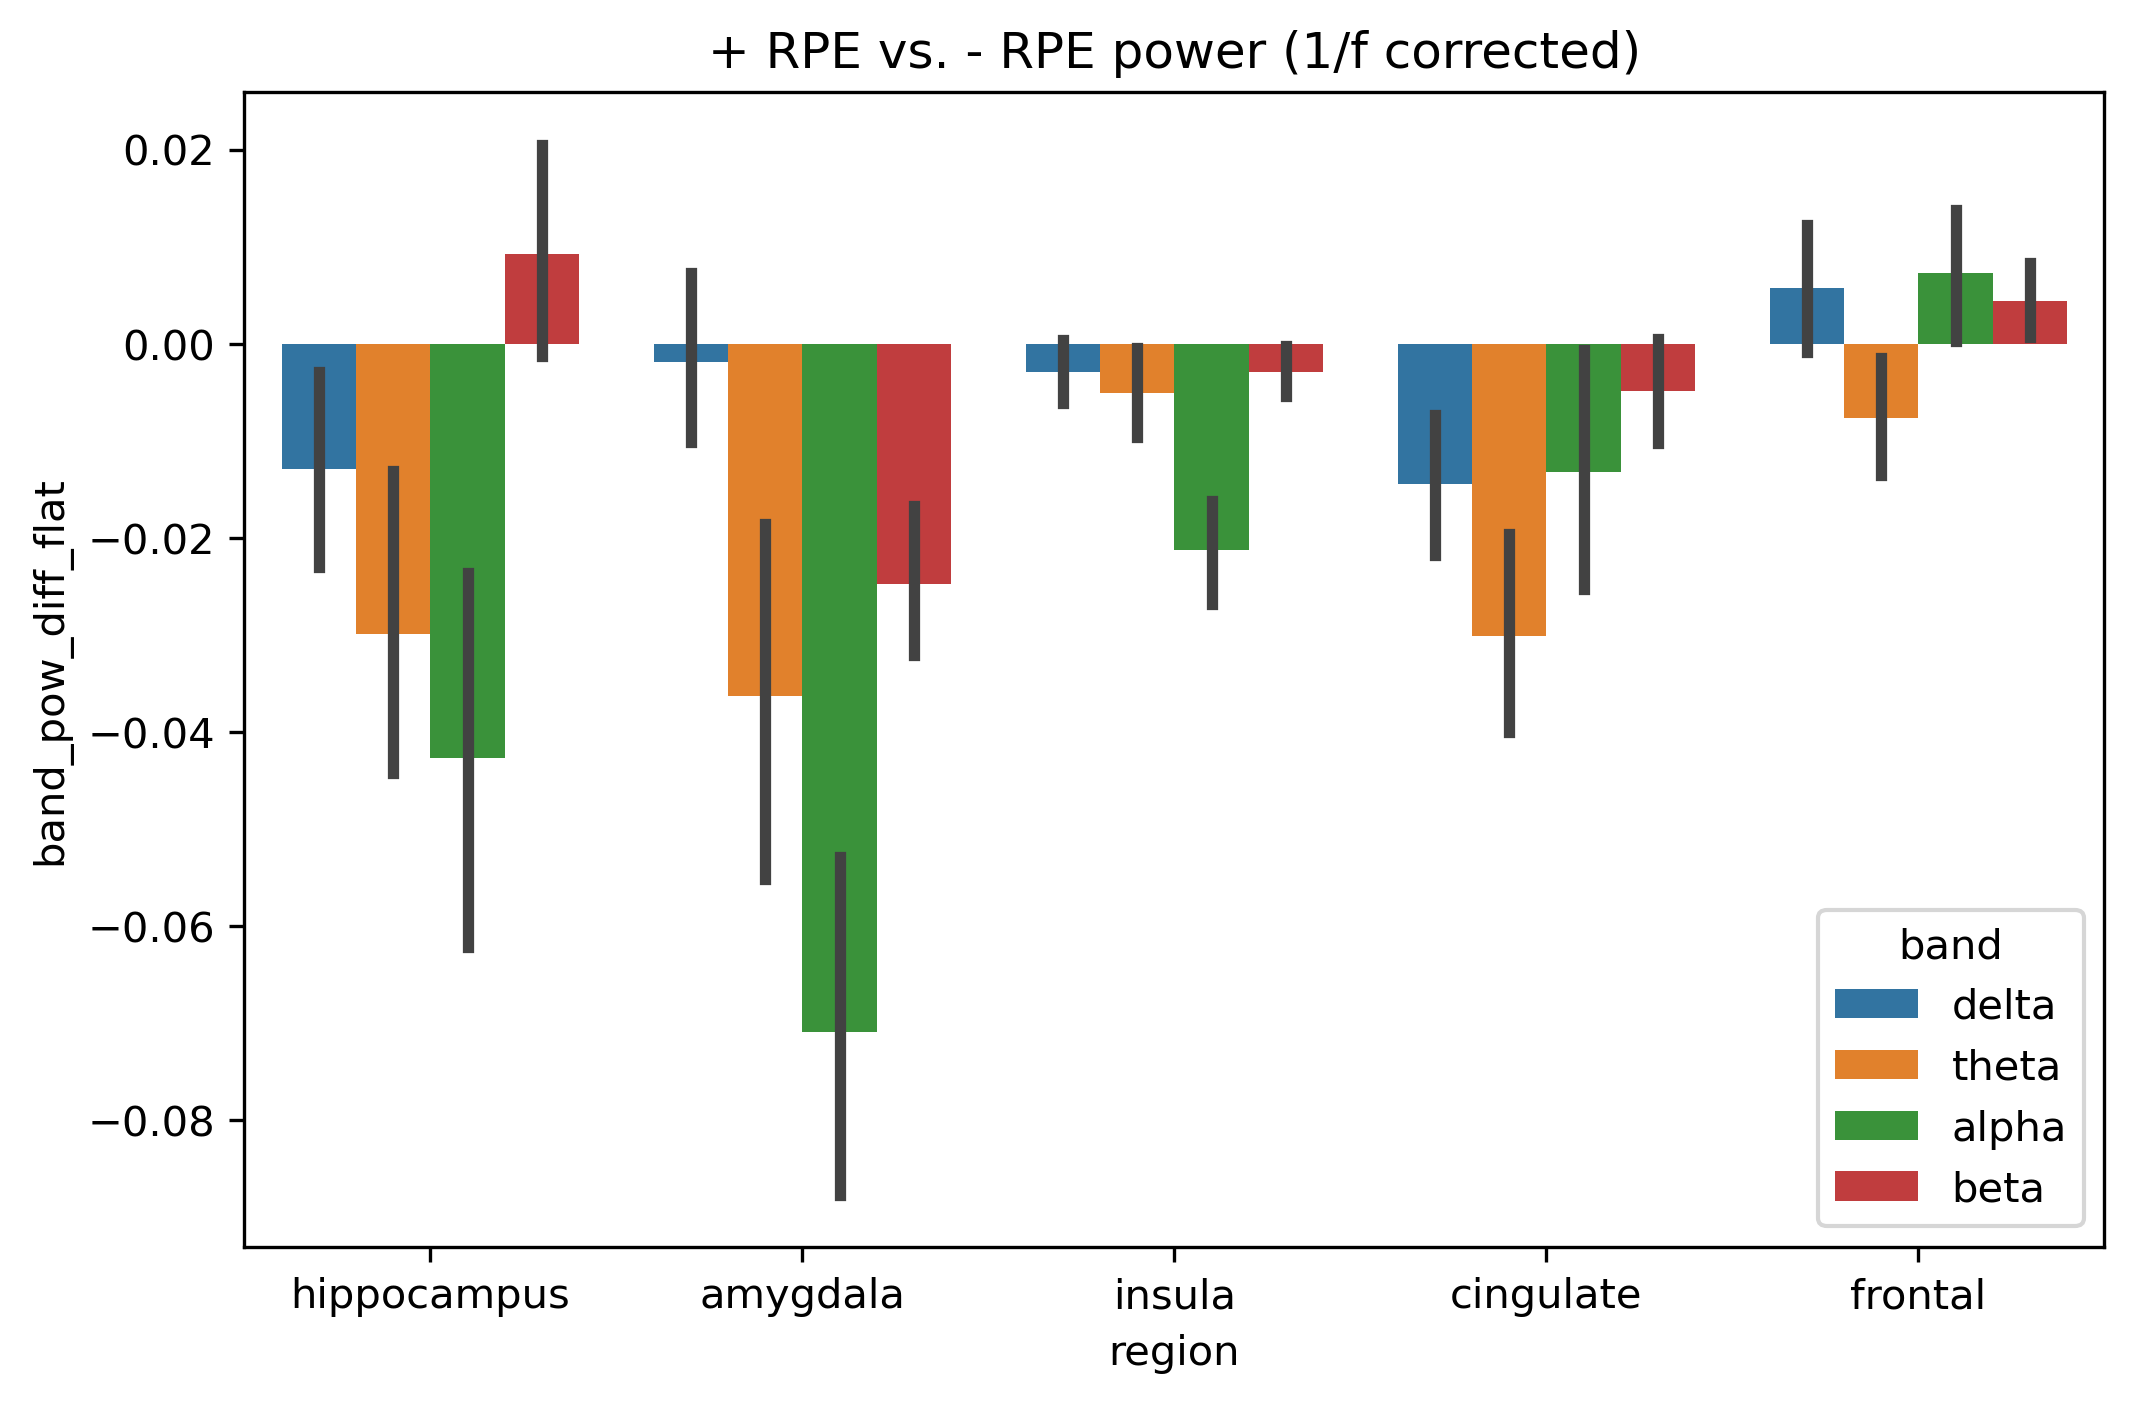

In [92]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5), dpi=300)

sns.barplot(data=compare_dfs, x='region', y='band_pow_diff_flat', hue='band', ci=68)

ax.set(title='+ RPE vs. - RPE power (1/f corrected)')

/tmp/ipykernel_192979/716836455.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 68)` for the same effect.

  sns.barplot(data=compare_dfs, x='region', y='peak_pow_diff', hue='band', ci=68)
/sc/arion/work/qasims01/test-env/envs/LFPAnalysis/lib/python3.10/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/sc/arion/work/qasims01/test-env/envs/LFPAnalysis/lib/python3.10/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))


[Text(0.5, 1.0, '+ RPE vs. - RPE power (peaks only)')]

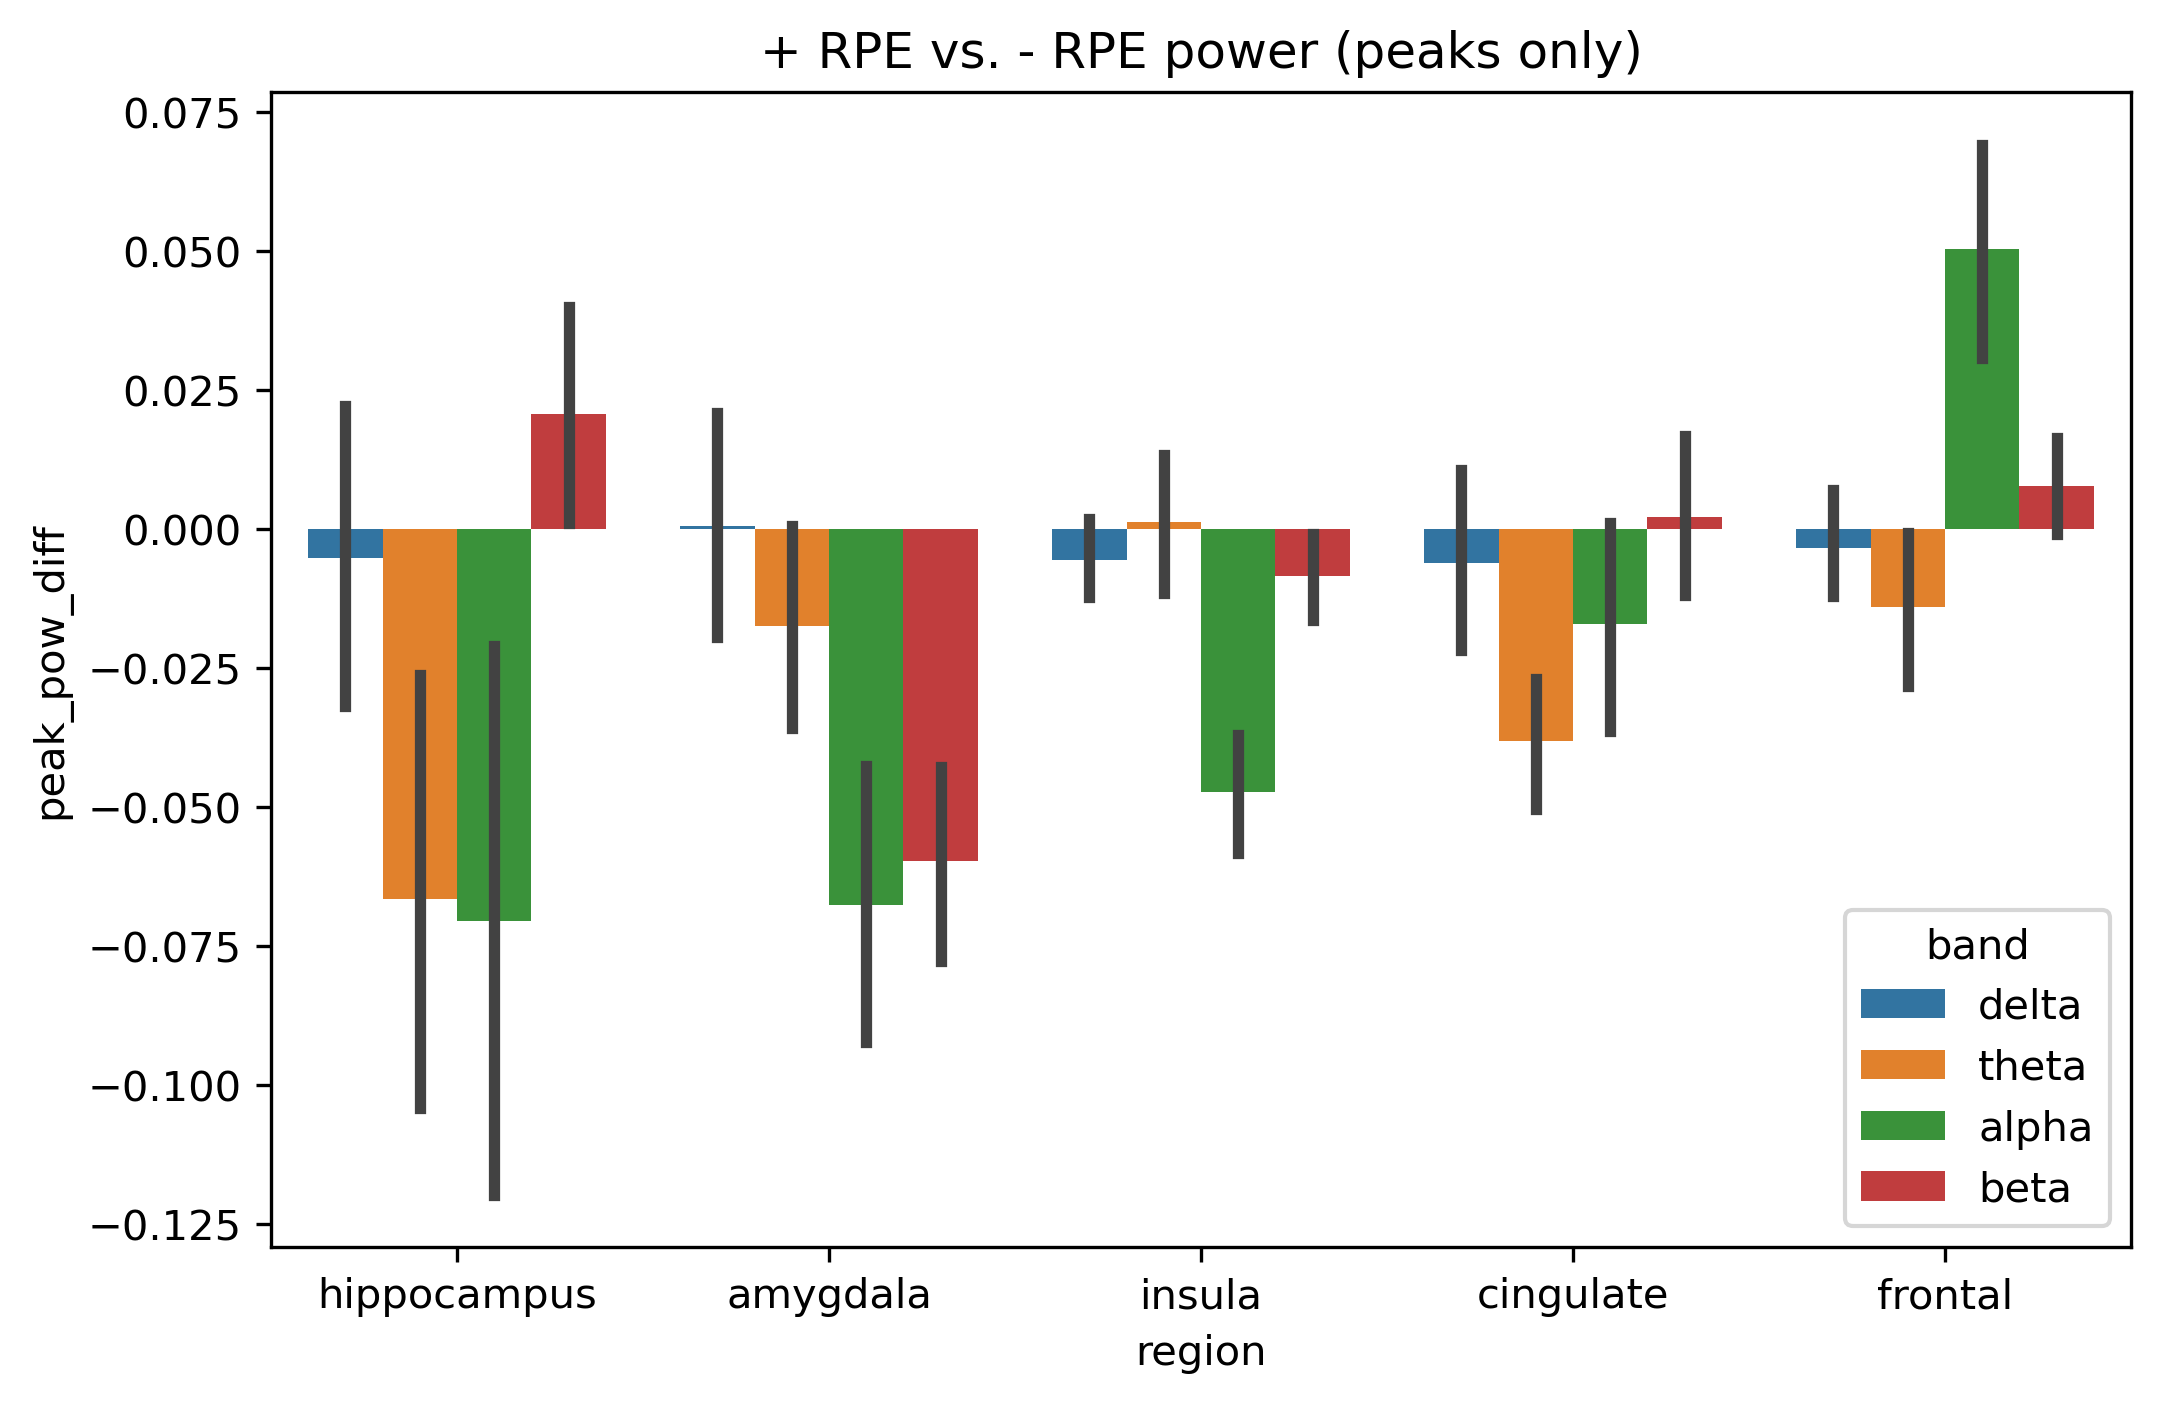

In [43]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5), dpi=300)

sns.barplot(data=compare_dfs, x='region', y='peak_pow_diff', hue='band', ci=68)

ax.set(title='+ RPE vs. - RPE power (peaks only)')

For guidance on picking the parameters used to fit: https://fooof-tools.github.io/fooof/auto_tutorials/plot_07-TroubleShooting.html#sphx-glr-auto-tutorials-plot-07-troubleshooting-py

# Statistical Analyses of Power spectra:


## GLM

Here, we will use the *statsmodels* package to implement a generalized-linear model approach to testing how task condition affects band-specific power. 

In [99]:
# Here, we used a mixed-effects linear model to account for subject-level random intercepts
model = smf.mixedlm(data=compare_dfs, formula='band_pow_diff_flat~ 0 + C(region)*C(band)', groups=compare_dfs['subj']).fit()


/sc/arion/work/qasims01/test-env/envs/LFPAnalysis/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [100]:
model.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                       Mixed Linear Model Regression Results
====================================================================================
Model:                    MixedLM       Dependent Variable:       band_pow_diff_flat
No. Observations:         1368          Method:                   REML              
No. Groups:               2             Scale:                    0.0034            
Min. group size:          296           Log-Likelihood:           1875.9532         
Max. group size:          1072          Converged:                Yes               
Mean group size:          684.0                                                     
------------------------------------------------------------------------------------
                                          Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------------------------
C(region)[amygdala]                       -0.071    0.014 -5.125 0.000 -0.098 -0.044
C(region)[cingulate]                      -0.013    0.012 -1.101 0.271 -0.037  0.010
C(region)[frontal]                         0.007    0.007  1.003 0.316 -0.007  0.021
C(region)[hippocampus]                    -0.043    0.013 -3.242 0.001 -0.068 -0.017
C(region)[insula]                         -0.021    0.005 -4.479 0.000 -0.031 -0.012
C(band)[T.beta]                            0.046    0.020  2.366 0.018  0.008  0.084
C(band)[T.delta]                           0.069    0.020  3.538 0.000  0.031  0.107
C(band)[T.theta]                           0.035    0.020  1.776 0.076 -0.004  0.073
C(region)[T.cingulate]:C(band)[T.beta]    -0.038    0.026 -1.465 0.143 -0.088  0.013
C(region)[T.frontal]:C(band)[T.beta]      -0.049    0.022 -2.225 0.026 -0.092 -0.006
C(region)[T.hippocampus]:C(band)[T.beta]   0.006    0.027  0.212 0.832 -0.047  0.058
C(region)[T.insula]:C(band)[T.beta]       -0.028    0.020 -1.373 0.170 -0.068  0.012
C(region)[T.cingulate]:C(band)[T.delta]   -0.070    0.026 -2.726 0.006 -0.121 -0.020
C(region)[T.frontal]:C(band)[T.delta]     -0.071    0.022 -3.208 0.001 -0.114 -0.027
C(region)[T.hippocampus]:C(band)[T.delta] -0.039    0.027 -1.460 0.144 -0.092  0.013
C(region)[T.insula]:C(band)[T.delta]      -0.051    0.020 -2.494 0.013 -0.090 -0.011
C(region)[T.cingulate]:C(band)[T.theta]   -0.052    0.026 -1.997 0.046 -0.102 -0.001
C(region)[T.frontal]:C(band)[T.theta]     -0.050    0.022 -2.251 0.024 -0.093 -0.006
C(region)[T.hippocampus]:C(band)[T.theta] -0.022    0.027 -0.815 0.415 -0.075  0.031
C(region)[T.insula]:C(band)[T.theta]      -0.019    0.020 -0.911 0.362 -0.058  0.021
Group Var                                  0.000    0.000                           
====================================================================================

"""

## Wavelet TFRs

Here, we will plot some basic TFRs of our behaviorally-locked analysis using a wavelet transform. We can also use these to compute the inter-trial phase coherence (ITC). 

Let's set some parameters first


Use the metadata to assign conditions to parse your epochs!

In [47]:
# Explicitly define a list of analysis events and the baseline event. Should correspond to the dict
analysis_evs = ['feedback_start']
baseline_ev = 'baseline_start'
evs = {'feedback_start': [0, 1.5],
       'baseline_start': [0, 0.75]}
for i in analysis_evs: 
    if i not in evs.keys(): 
        raise ValueError('This analysis event is not in the dictionary')

In [48]:
# Set some spectrogram parameters 
freqs = np.logspace(*np.log10([4, 120]), num=20)
n_cycles = 4  
sr = epochs_all_subjs_all_evs[subj_id][baseline_ev].info['sfreq']
buf = 1.0
buf_ix = int(buf*sr)


baseline_power_epochs = {f'{a}': {f'{b}': np.nan for b in evs.keys()} for a in subj_ids}

power_epochs = {f'{a}': {f'{b}': np.nan for b in evs.keys()} for a in subj_ids}

First, compute the baseline power:

In [49]:

# Compute baseline_power
for subj_id in subj_ids:
    event = 'baseline_start'
    epochs = epochs_all_subjs_all_evs[subj_id][event]
        
    # Let's make sure we only do this for good channels
    good_chans = [x for x in epochs.ch_names if x not in epochs.info['bads']]
    picks = [x for x in good_chans]

    pow_struct = np.nan * np.ones([epochs._data.shape[0], 
                           epochs._data.shape[1], len(freqs), 
                           epochs._data.shape[-1]])

    for ch_ix in np.arange(epochs._data.shape[1]): 
        ch_data = epochs._data[:, ch_ix:ch_ix+1, :]
        bad_epochs  = np.where(epochs.metadata[epochs.ch_names[ch_ix]].notnull())[0]
        good_epochs = np.delete(np.arange(ch_data.shape[0]), bad_epochs)
        ch_data = np.delete(ch_data, bad_epochs, axis=0)
        ch_pow = mne.time_frequency.tfr_array_morlet(ch_data, sfreq=epochs.info['sfreq'], 
                                            freqs=freqs, n_cycles=n_cycles, zero_mean=False, 
                                            use_fft=True, output='power', n_jobs=1)

        pow_struct[good_epochs, ch_ix, :, :] = ch_pow[:, 0, :, :]

    temp_pow = mne.time_frequency.EpochsTFR(epochs.info, pow_struct, 
                                            epochs.times, freqs)
    temp_pow.crop(tmin=evs[event][0], tmax=evs[event][1])

    baseline_power_epochs[subj_id][event] = temp_pow

 - baseline_power_epochs: a dictionary containing all of your subjects' baseline TFR, with the buffer cropped out

Next, compute the power for the analysis events and BASELINE it using the baseline epochs: 

In [51]:
for subj_id in subj_ids:
    for event in analysis_evs:
                
        epochs = epochs_all_subjs_all_evs[subj_id][event]
            
        # Let's make sure we only do this for good channels
        good_chans = [x for x in epochs.ch_names if x not in epochs.info['bads']]
        picks = [x for x in good_chans]
        
        pow_struct = np.nan * np.ones([epochs._data.shape[0], 
                               epochs._data.shape[1], len(freqs), 
                               epochs._data.shape[-1]])

        for ch_ix in np.arange(epochs._data.shape[1]): 
            ch_data = epochs._data[:, ch_ix:ch_ix+1, :]
            bad_epochs  = np.where(epochs.metadata[epochs.ch_names[ch_ix]].notnull())[0]
            good_epochs = np.delete(np.arange(ch_data.shape[0]), bad_epochs)
            ch_data = np.delete(ch_data, bad_epochs, axis=0)
            ch_pow = mne.time_frequency.tfr_array_morlet(ch_data, sfreq=epochs.info['sfreq'], 
                                                freqs=freqs, n_cycles=n_cycles, zero_mean=False, 
                                                use_fft=True, output='power', n_jobs=1)

            pow_struct[good_epochs, ch_ix, :, :] = ch_pow[:, 0, :, :]
        
        temp_pow = mne.time_frequency.EpochsTFR(epochs.info, pow_struct, 
                                                epochs.times, freqs)
        
        temp_pow.crop(tmin=evs[event][0], tmax=evs[event][1])
        
        baseline_corrected_power = lfp_preprocess_utils.zscore_TFR_across_trials(temp_pow.data, 
                                      baseline_power_epochs[subj_id]['baseline_start'], mode='zscore', baseline_only=False)
        
        zpow = mne.time_frequency.EpochsTFR(epochs.info, baseline_corrected_power, 
                                        temp_pow.times, freqs)
        
        zpow.metadata = epochs_all_subjs_all_evs[subj_id][event].metadata
        
        power_epochs[subj_id][event] = zpow
        

/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/lfp_preprocess_utils.py:137: RuntimeWarning: Mean of empty slice
  m = np.nanmean(np.nanmean(baseline_data, axis=time_axis), axis=ev_axis)
/sc/arion/work/qasims01/test-env/envs/LFPAnalysis/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


 - power_epochs: a dictionary containing all of your subjects' event TFR, with the buffer cropped out and NORMALIZED with the baseline + event period 

In [52]:
power_epochs['MS025']['feedback_start'].metadata.head(5)

lacas1-lacas4 lacas2-lacas4 lacas3-lacas4 lacas6-lacas5 laglt1-laglt5  \
0          None          None          None          None          None   
1          None          None          None          None          None   
2          None          None          None          None          None   
3          None          None          None          None          None   
4          None          None          None          None          None   

  laglt2-laglt5 laglt3-laglt5 laglt7-lhplt6 laglt8-lhplt7 laglt9-lhplt8  ...  \
0          None          None          None          None          None  ...   
1          None          None          None          None          None  ...   
2          None          None          None          None          None  ...   
3          None          None          None          None          None  ...   
4          None          None          None          None          None  ...   

  rpvnh11-rpvnh9 rpvnh2-rcmip8 rpvnh3-rcmip7 rpvnh4-rcmip8 rpvnh5-rpvnh8  \
0           None          None          None          None          None   
1           None          None          None          None          None   
2           None          None          None          None          None   
3           None          None          None          None          None   
4           None          None          None          None          None   

          rt reward image_dprime       rpe   region  
0  16.255064    1.0     2.337818  0.500000  frontal  
1   4.730283    0.0     1.975903 -0.775057  frontal  
2   4.093465    1.0     1.726771  0.651313  frontal  
3   4.179714    0.0     1.675859 -0.500000  frontal  
4   1.786383    1.0     1.953028  0.293016  frontal  

[5 rows x 99 columns]

Now, let's compute the average spectrogram over some particular region: hippocampus, in this example

/tmp/ipykernel_192979/2278125545.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  elec_df['label'] = epochs_all_subjs_all_evs[subj_id][event].ch_names
/tmp/ipykernel_192979/2278125545.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  elec_df['label'] = epochs_all_subjs_all_evs[subj_id][event].ch_names


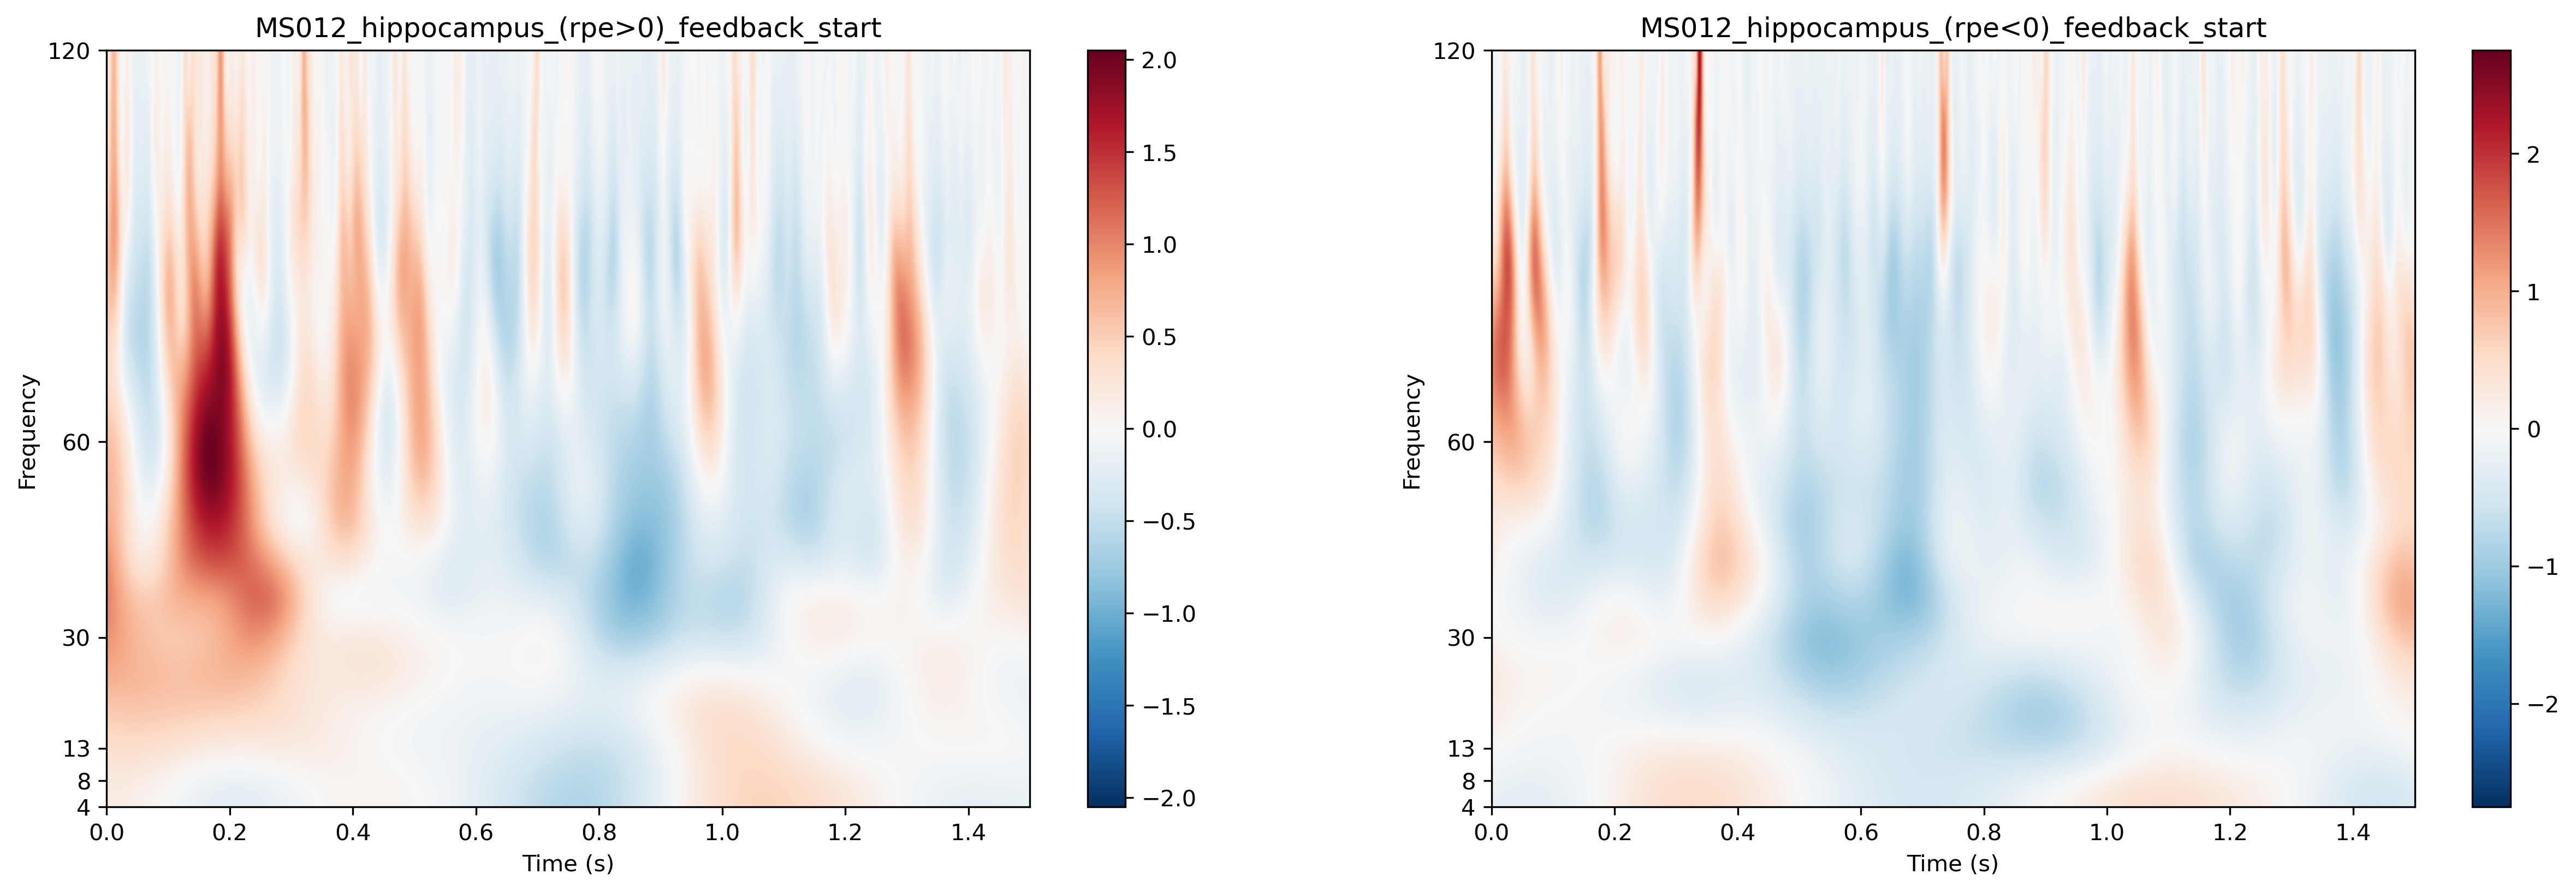

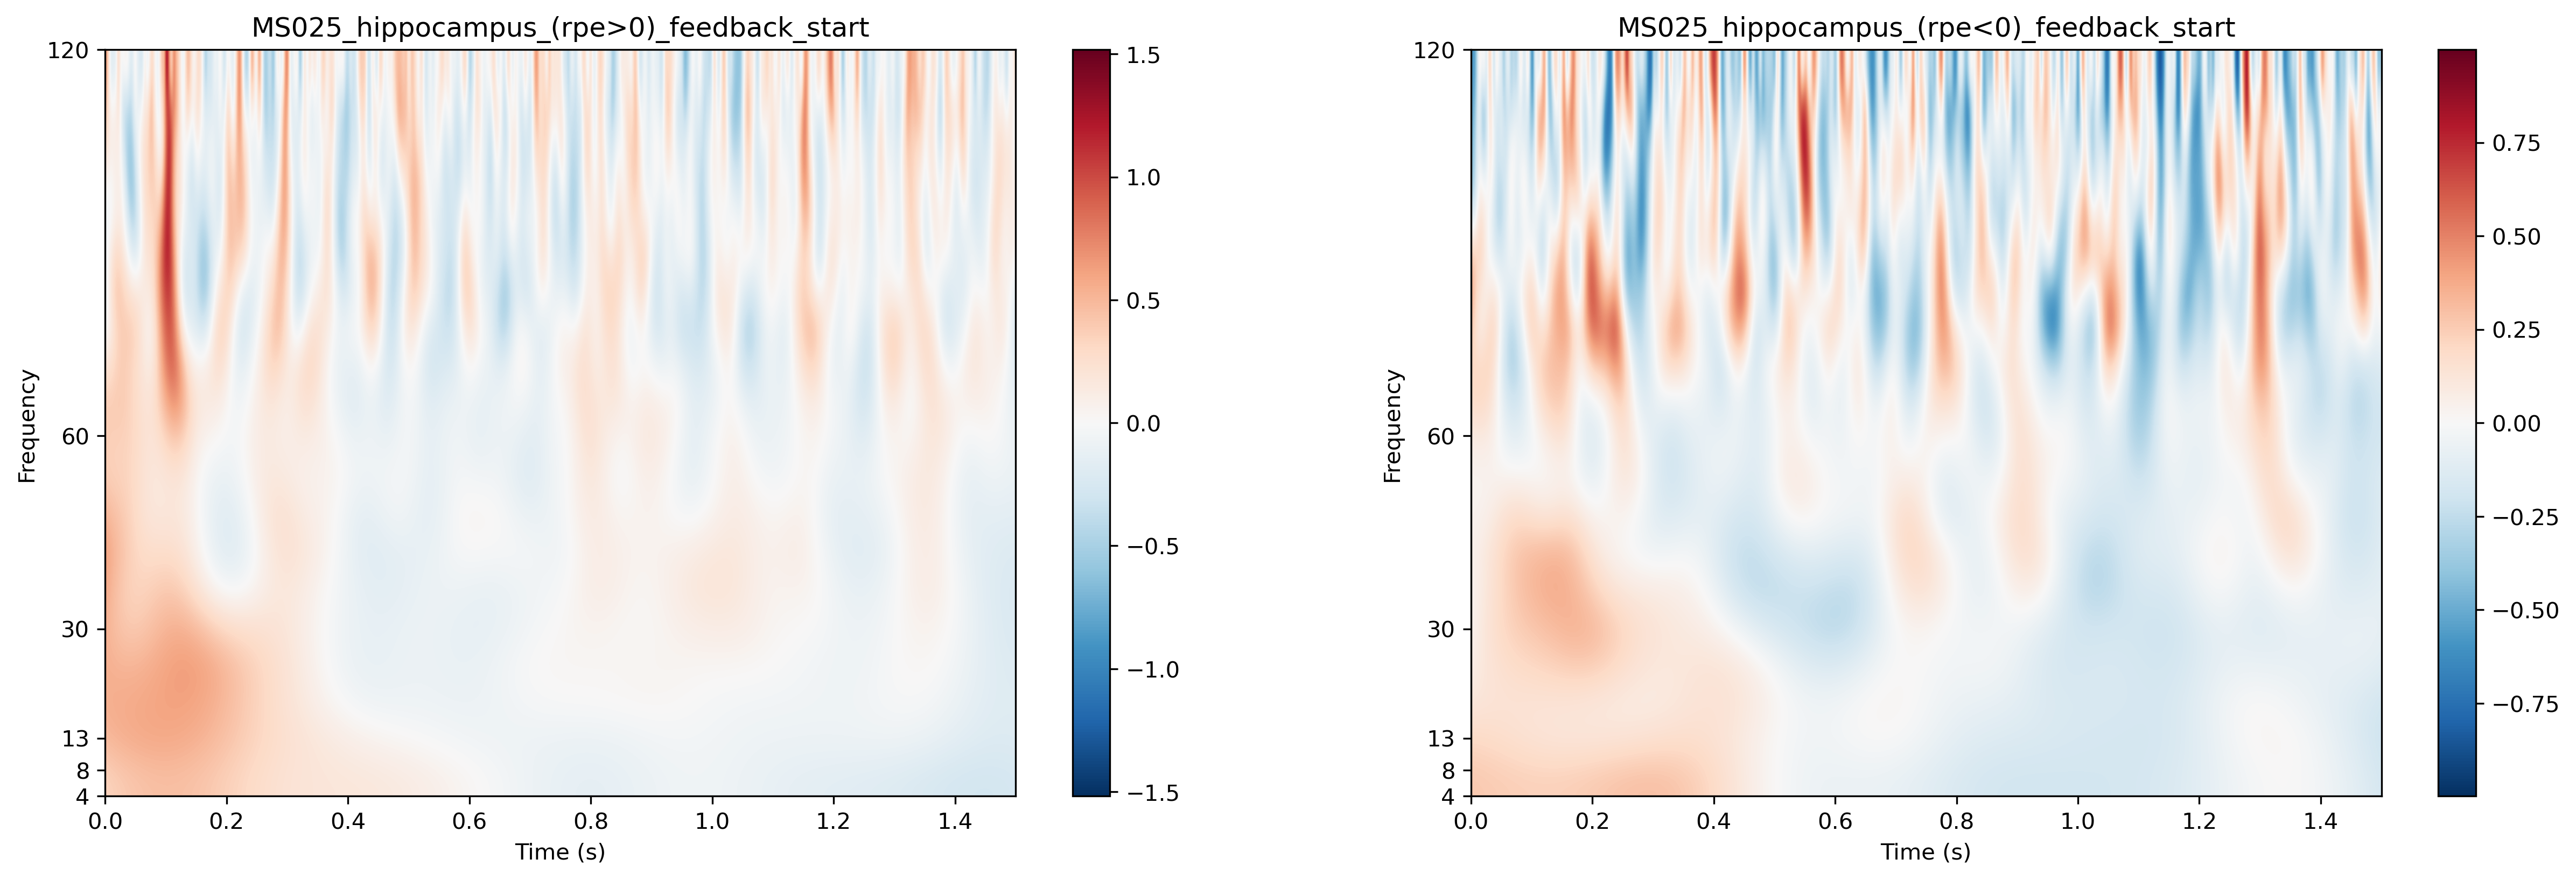

In [58]:
# rois = ['hippocampus', 'amygdala', 'insula', 'cingulate' ,'frontal']
region = 'hippocampus'

# band definitions for y-axis
yticks = [4, 8, 13, 30, 60, 120]

# task condition to contrast 
conditions = ["(rpe>0)",
             "(rpe<0)"]

cond_name = 'rpe'


for subj_id in subj_ids:
    save_path = f'{base_dir}/work/qasims01/MemoryBanditData/EMU/Subjects/{subj_id}'
    # Get electrode df 
    elec_path = f'{base_dir}/projects/guLab/Salman/EMU/{subj_id}/anat/'
    # electrode files could either be csv or excel
    elec_files = glob(f'{elec_path}/*.csv') + glob(f'{elec_path}/*.xlsx')
    # There should really only be one 
    elec_file = elec_files[0]
    elec_data = lfp_preprocess_utils.load_elec(elec_file)

    anode_list = [x.split('-')[0] for x in epochs_all_subjs_all_evs[subj_id][event].ch_names]
    elec_df = elec_data[elec_data.label.str.lower().isin(anode_list)]
    elec_df['label'] = epochs_all_subjs_all_evs[subj_id][event].ch_names

    picks = analysis_utils.select_picks_rois(elec_df, region)
    
    for event in analysis_evs:
        fig, ax = plt.subplots(1, 2, figsize=(20, 6), dpi=300)
        for ix, cond in enumerate(conditions):
            # Set the times for 
            times = power_epochs[subj_id][event].times
            plot_data = np.nanmean(np.nanmean(power_epochs[subj_id][event][cond].copy().pick_channels(picks).data, axis=0), axis=0)

            im = ax[ix].imshow(plot_data,
                      extent=[times[0], times[-1], freqs[0], freqs[-1]], interpolation='Bicubic',
                      aspect='auto', origin='lower', cmap='RdBu_r', vmin = -np.nanmax(np.abs(plot_data)), vmax = np.nanmax(np.abs(plot_data)))
            ax[ix].set(yticks=yticks, xlabel='Time (s)', ylabel='Frequency', title=f'{subj_id}_{region}_{cond}_{event}')
            fig.colorbar(im, ax=ax[ix])


# Statistical Analyses of TFRs:

At this stage, you should **heavily** brainstorm the statistics you want to do, before you start writing any code. What is the goal of your analysis? What would actually allow you to show what you want to show?

As an example, let's say I want to compare the positive RPE vs. negative RPE conditions for every channel, and identify the timepoints and frequencies that exhibit significant differences between conditions. To do so, I would utilize a non-parametric cluster-permutation test.

## Cluster-permutation test

/tmp/ipykernel_192979/2050235520.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  elec_df['label'] = epochs_all_subjs_all_evs[subj_id][event].ch_names
/tmp/ipykernel_192979/2050235520.py:31: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  mne.stats.permutation_cluster_test(X, n_permutations=500, out_type='mask', verbose=True)


  0%|          | Permuting : 0/499 [00:00<?,       ?it/s]

frontal


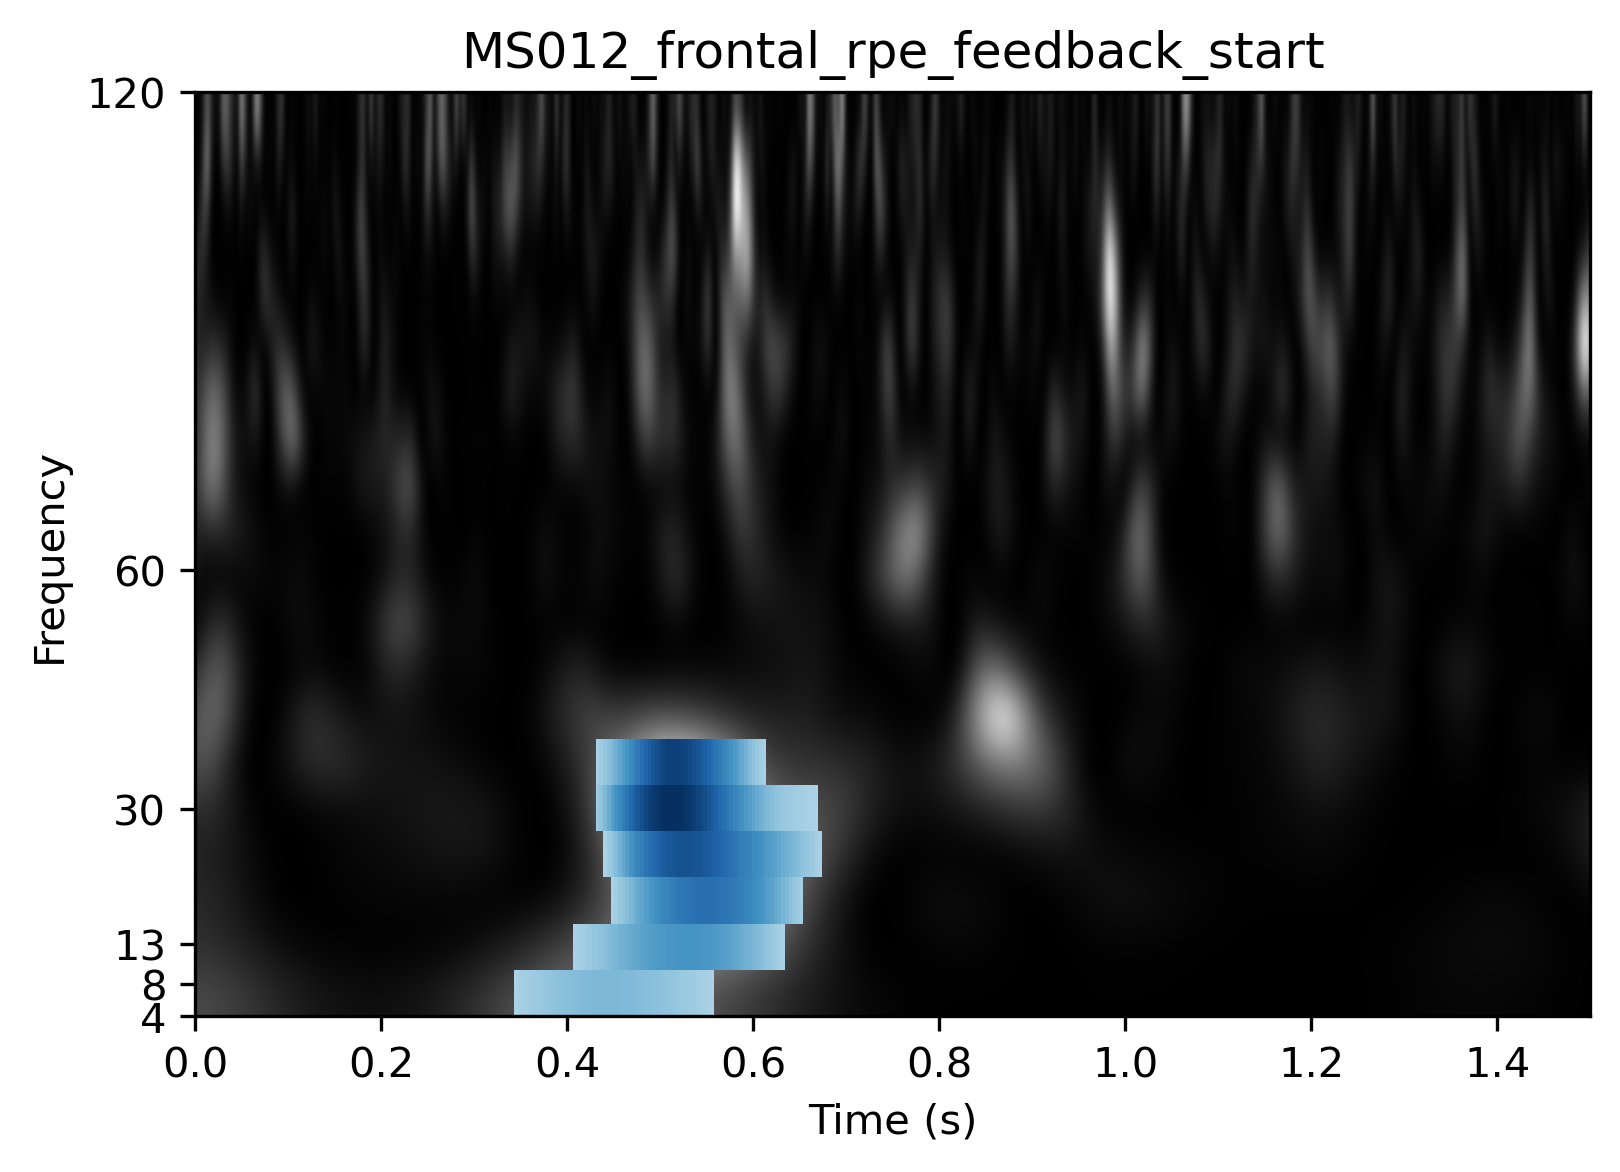

In [150]:
subj_id = 'MS012'
region = 'frontal'

save_path = f'{base_dir}/work/qasims01/MemoryBanditData/EMU/Subjects/{subj_id}'
# Get electrode df 
elec_path = f'{base_dir}/projects/guLab/Salman/EMU/{subj_id}/anat/'
# electrode files could either be csv or excel
elec_files = glob(f'{elec_path}/*.csv') + glob(f'{elec_path}/*.xlsx')
# There should really only be one 
elec_file = elec_files[0]
elec_data = lfp_preprocess_utils.load_elec(elec_file)

anode_list = [x.split('-')[0] for x in epochs_all_subjs_all_evs[subj_id][event].ch_names]
elec_df = elec_data[elec_data.label.str.lower().isin(anode_list)]
elec_df['label'] = epochs_all_subjs_all_evs[subj_id][event].ch_names
    
picks = analysis_utils.select_picks_rois(elec_df, region)

conditions = ["(rpe>0)",
             "(rpe<0)"]
cond_name = 'rpe'


for event in analysis_evs:
    
    # Average the data in each condition across channels 
    X = [np.nanmean(power_epochs[subj_id][event][conditions[0]].copy().pick_channels(picks).data, axis=1), 
         np.nanmean(power_epochs[subj_id][event][conditions[1]].copy().pick_channels(picks).data, axis=1)]
    
    F_obs, clusters, cluster_p_values, H0 = \
    mne.stats.permutation_cluster_test(X, n_permutations=500, out_type='mask', verbose=True)
    
#     if any(cluster_p_values<=0.05):
    print(region)
    # Create new stats image with only significant clusters
    fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=300)

    times =  power_epochs[subj_id][event][conditions[0]].times


    # Average the data in each condition across epochs for plotting
    evoked_power_1 = np.nanmean(X[0], axis=0)
    evoked_power_2 = np.nanmean(X[1], axis=0)
    evoked_power_contrast = evoked_power_1 - evoked_power_2
    signs = np.sign(evoked_power_contrast)

    F_obs_plot = np.nan * np.ones_like(F_obs)
    for c, p_val in zip(clusters, cluster_p_values):
        if p_val <= 0.05:
            F_obs_plot[c] = F_obs[c] * signs[c]

    ax.imshow(F_obs,
              extent=[times[0], times[-1], freqs[0], freqs[-1]], interpolation = 'Bicubic',
              aspect='auto', origin='lower', cmap='gray')
    max_F = np.nanmax(abs(F_obs_plot))
    ax.imshow(F_obs_plot,
              extent=[times[0], times[-1], freqs[0], freqs[-1]],
              aspect='auto', origin='lower', cmap='RdBu_r',
              vmin=-max_F, vmax=max_F)

    ax.set(yticks=yticks, xlabel='Time (s)', ylabel='Frequency', title=f'{subj_id}_{region}_{cond_name}_{event}')

        # # ax.set_title(f'Induced power ({ch_name})')
    
    

In [151]:
cluster_p_values

array([0.038, 1.   , 0.57 , 0.984, 1.   , 1.   , 1.   , 1.   , 1.   ,
       0.762, 1.   , 1.   , 0.978, 1.   , 1.   , 1.   , 1.   , 1.   ,
       1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   ,
       1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   ,
       1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   ])

## GLM

TODO

======================================================================================================================

# Experimental

## Empirical mode decomposition for cycle/burst detection (WIP)

The benefit of EMD is that we get away from assumptions of sinuisoidal oscillations and linearity in the time-series. 

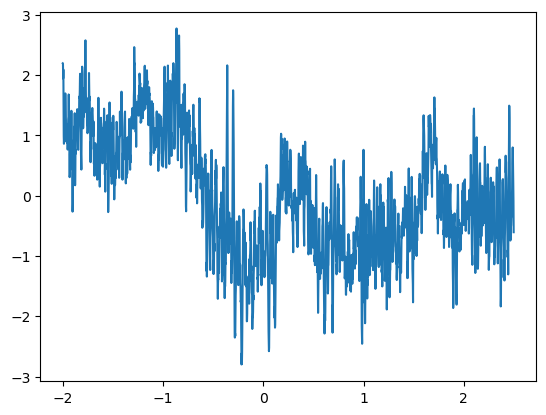

In [327]:
# Zscore the data first (idk why, but otherwise unable to plot IMFs) 

test_epoch = zscore(epochs_all_subjs_all_evs[subj_id][event]._data[0, 26, :])
time_vect = epochs_all_subjs_all_evs[subj_id][event].times
sample_rate = int(epochs_all_subjs_all_evs[subj_id][event].info['sfreq'])
plt.plot(time_vect, test_epoch)

<AxesSubplot:xlabel='Time (samples)'>

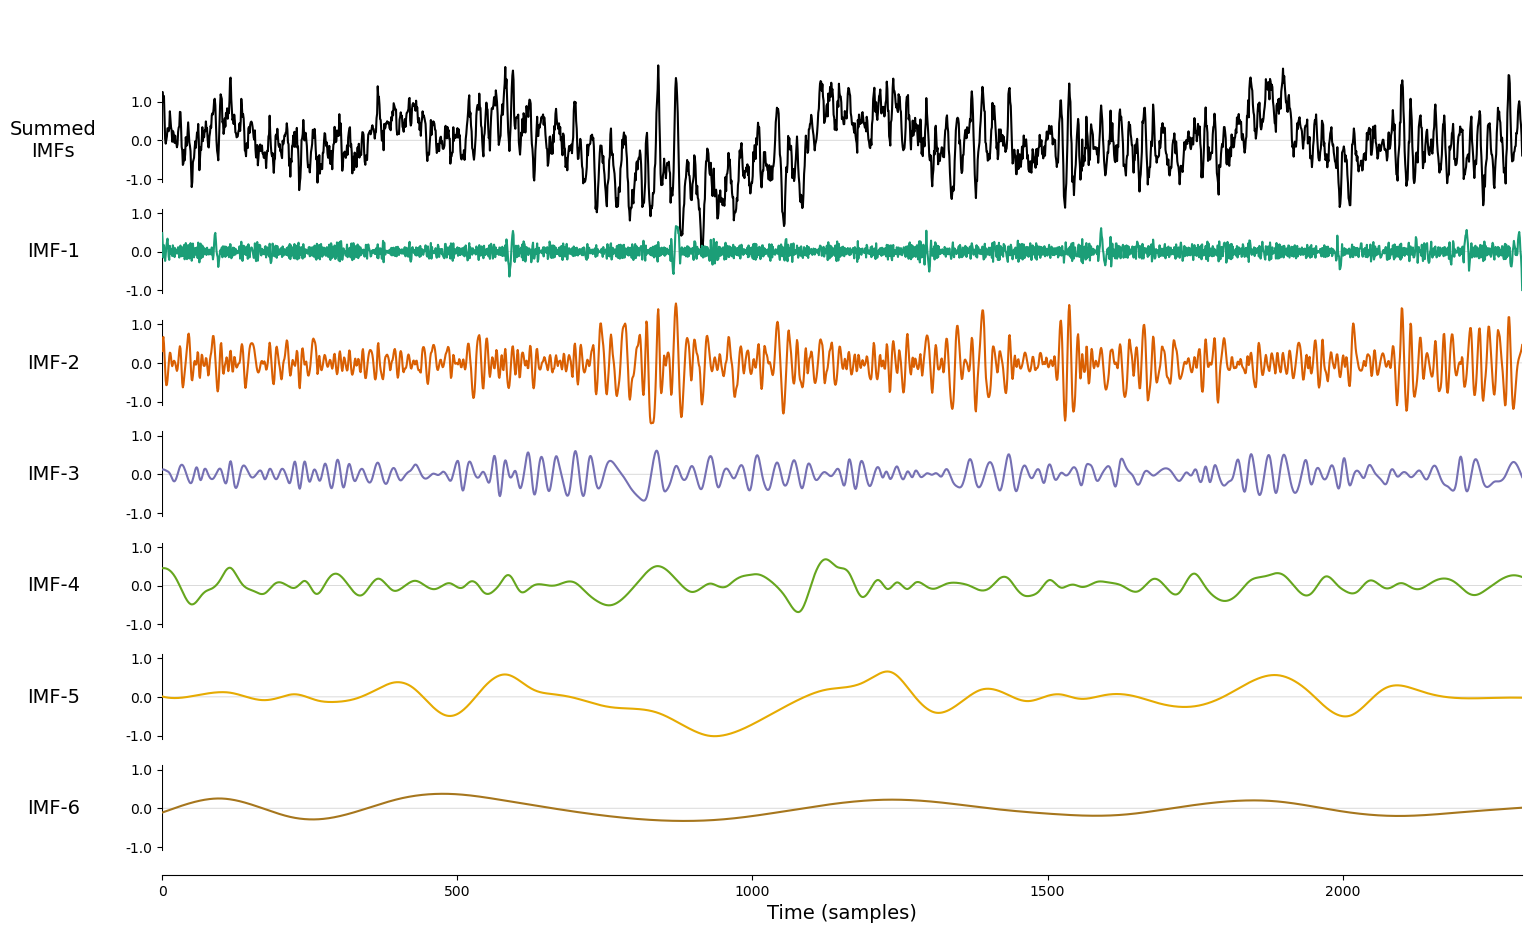

In [328]:
imf = emd.sift.sift(test_epoch, max_imfs=6)
# Visualise the IMFs
emd.plotting.plot_imfs(imf)

Here, it looks like IMF-2 might have some meaningful oscillatory bursts in it

from the IMFs, compute the instantaneous frequency, phase and amplitude using the Normalised Hilbert Transform Method

In [334]:
IP, IF, IA = emd.spectra.frequency_transform(imf, sample_rate, 'hilbert')
# Extract cycle locations
all_cycles = emd.cycles.get_cycle_vector(IP, return_good=False)
good_cycles = emd.cycles.get_cycle_vector(IP, return_good=True)

# ``all_cycles`` is an array of the same size as the input instantaneous phase.
# Each row contains a vector of itegers indexing the location of successive
# cycles for that IMF.

# Set a 33% amplitude threshold on IMF-1 

thresh = np.percentile(IA[:, 1], 33)
mask = IA[:, 1] > thresh

mask_cycles = emd.cycles.get_cycle_vector(IP, return_good=True, mask=mask)

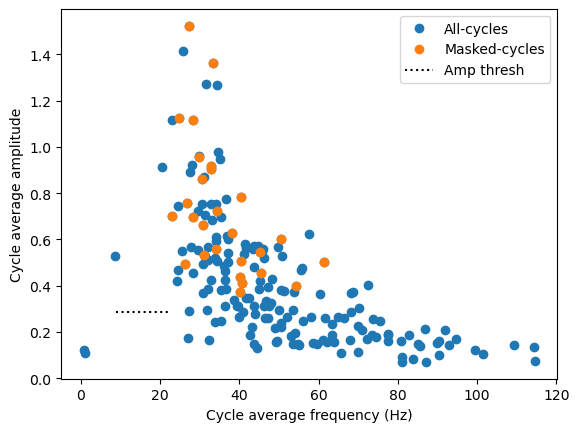

In [335]:

# Compute cycle average frequency for all cycles and masked cycles
all_cycle_freq = emd.cycles.get_cycle_stat(all_cycles[:, 1], IF[:, 1], func=np.mean)
mask_cycle_freq = emd.cycles.get_cycle_stat(mask_cycles[:, 1], IF[:, 1], func=np.mean)

# Compute cycle frequency range for all cycles and for masked cycles
all_cycle_amp = emd.cycles.get_cycle_stat(all_cycles[:, 1], IA[:, 1], func=np.mean)
mask_cycle_amp = emd.cycles.get_cycle_stat(mask_cycles[:, 1], IA[:, 1], func=np.mean)

# Make a summary figures
plt.figure()
plt.plot(all_cycle_freq, all_cycle_amp, 'o')
plt.plot(mask_cycle_freq, mask_cycle_amp, 'o')
plt.xlabel('Cycle average frequency (Hz)')
plt.ylabel('Cycle average amplitude')
plt.plot((9, 22), (thresh, thresh), 'k:')
plt.legend(['All-cycles', 'Masked-cycles', 'Amp thresh'])

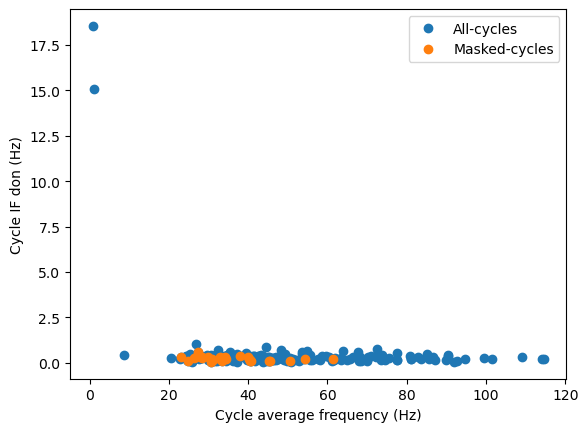

In [336]:
# Compute cycle average frequency for all cycles and masked cycles
all_cycle_freq = emd.cycles.get_cycle_stat(all_cycles[:, 1], IF[:, 1], func=np.mean)
mask_cycle_freq = emd.cycles.get_cycle_stat(mask_cycles[:, 1], IF[:, 1], func=np.mean)


# Define a simple function to compute the range of a set of values
def degree_nonlinearity(x):
    return np.std((x - x.mean()) / x.mean())


# Compute cycle freuquency range for all cycles and for masked cycles
all_cycle_freq_don = emd.cycles.get_cycle_stat(all_cycles[:, 1], IF[:, 1],
                                               func=degree_nonlinearity)
cycle_freq_don = emd.cycles.get_cycle_stat(mask_cycles[:, 1], IF[:, 1],
                                           func=degree_nonlinearity)

# Make a summary figures
plt.figure()
plt.plot(all_cycle_freq, all_cycle_freq_don, 'o')
plt.plot(mask_cycle_freq, cycle_freq_don, 'o')
plt.xlabel('Cycle average frequency (Hz)')
plt.ylabel('Cycle IF don (Hz)')
plt.legend(['All-cycles', 'Masked-cycles'])

In [337]:
C = emd.cycles.Cycles(IP[:, 1])


In [345]:
C.compute_cycle_metric('max_amp', IA[:, 1], func=np.max)
# Compute the length of each cycle
C.compute_cycle_metric('duration', IA[:, 1], len)


In [347]:
df = C.get_metric_dataframe()
print(df)

     is_good   max_amp  duration
0          0  0.712878        12
1          0  0.408407         7
2          0  0.340272         9
3          0  0.632888        12
4          0  0.762989        17
..       ...       ...       ...
183        1  1.036988        16
184        1  0.985259        17
185        0  1.232302        18
186        1  1.261188        18
187        0  0.631540         8

[188 rows x 3 columns]


(0.0, 60.0)

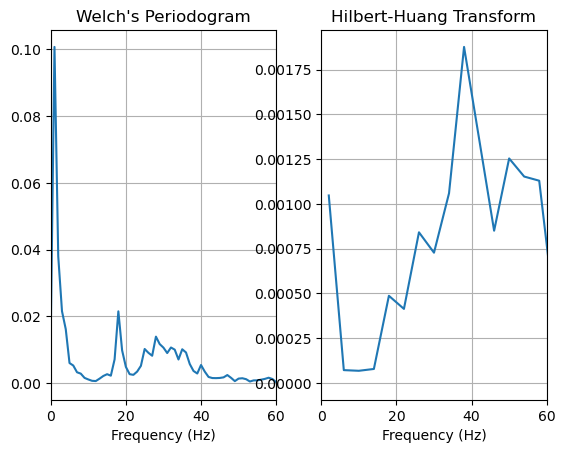

In [364]:
from scipy import signal 
fft_f, pxx_linear = signal.welch(test_epoch, fs=sample_rate, nperseg=512)

# Summary figure
plt.figure()
plt.subplot(121)
plt.plot(fft_f, pxx_linear)
plt.title("Welch's Periodogram")
# plt.xlim(0, 20)
# plt.xticks(np.arange(10)*2)
plt.grid(True)
plt.xlabel('Frequency (Hz)')

# Hilbert-Huang transform
freq_range = (0, 256, 64)
hht_f, spec_linear = emd.spectra.hilberthuang(IF, IA, freq_range, scaling='density', sum_imfs=False)

plt.xlim(0, 60)
plt.subplot(122)
plt.plot(hht_f, spec_linear[:, 0])
# plt.xticks(np.arange(10)*2)
plt.grid(True)
plt.title("Hilbert-Huang Transform")
plt.xlabel('Frequency (Hz)')
plt.xlim(0, 60)

In [355]:
fft_f.shape

(257,)

From the instantaneous frequency and amplitude, we can compute the Hilbert-Huang spectrum:



In [195]:
# Define frequency range (low_freq, high_freq, nsteps, spacing)
freq_range = (0.1, 30, 80, 'log')
f, hht = emd.spectra.hilberthuang(IF, IA, freq_range, sum_time=False)

<AxesSubplot:title={'center':'Hilbert-Huang Transform'}, xlabel='Time', ylabel='Frequency'>

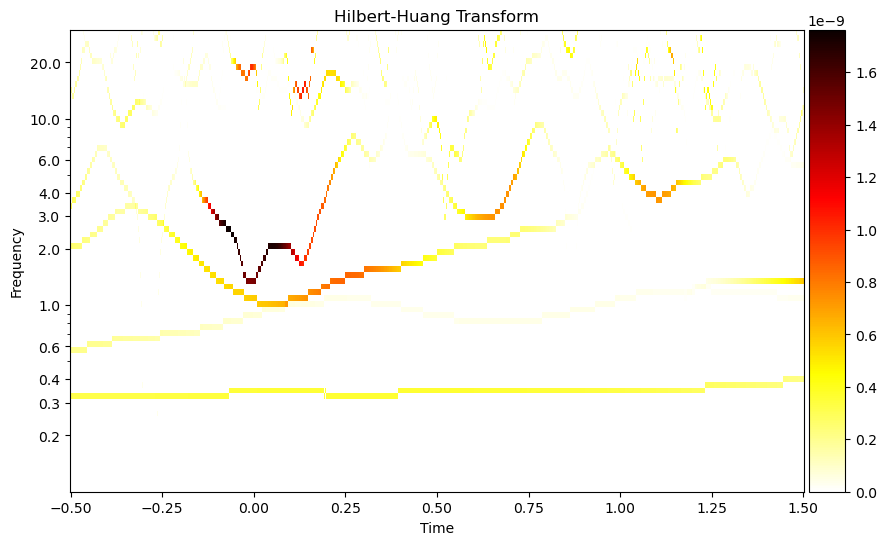

In [199]:
fig = plt.figure(figsize=(10, 6))
emd.plotting.plot_hilberthuang(hht, time_vect, f,
                               time_lims=(-0.5, 1.5), freq_lims=(0.1, 30),
                               fig=fig, log_y=True)

## Ripple detection

## Non-spectral time-series features

## PSID